In [2]:
# install prerequinces for the demo
import sys
!{sys.executable} -m pip install -r requirements.txt

  Using cached numpy-1.19.4-cp36-cp36m-manylinux2010_x86_64.whl (14.5 MB)
  Using cached matplotlib-3.3.3-cp36-cp36m-manylinux1_x86_64.whl (11.6 MB)
  Using cached ipywidgets-7.5.1-py2.py3-none-any.whl (121 kB)
  Using cached tqdm-4.39.0-py2.py3-none-any.whl (53 kB)
  Using cached itk-5.1.2-cp36-cp36m-manylinux1_x86_64.whl (7.6 kB)
  Using cached itk_core-5.1.2-cp36-cp36m-manylinux1_x86_64.whl (50.1 MB)
  Using cached itk_filtering-5.1.2-cp36-cp36m-manylinux1_x86_64.whl (68.0 MB)
  Using cached itk_io-5.1.2-cp36-cp36m-manylinux1_x86_64.whl (14.0 MB)
  Using cached itk_meshtopolydata-0.6.2-cp36-cp36m-manylinux1_x86_64.whl (593 kB)
  Using cached itk_numerics-5.1.2-cp36-cp36m-manylinux1_x86_64.whl (36.3 MB)
  Using cached itk_registration-5.1.2-cp36-cp36m-manylinux1_x86_64.whl (14.4 MB)
  Using cached itk_segmentation-5.1.2-cp36-cp36m-manylinux1_x86_64.whl (10.3 MB)
  Using cached itkwidgets-0.23.1-py2.py3-none-any.whl (3.7 MB)
  Using cached segyio-1.9.1-cp36-cp36m-manylinux1_x86_64.whl

  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.6.3
    Uninstalling ipywidgets-7.6.3:
      Successfully uninstalled ipywidgets-7.6.3
You should consider upgrading via the '/home/akhorkin/.virtualenvs/python_demo_env/bin/python -m pip install --upgrade pip' command.


In [3]:
# Download dataset
! wget https://zenodo.org/record/3755060/files/data.zip
! unzip data.zip
! rm -rf data.zip data/train

--2021-01-26 18:36:34--  https://zenodo.org/record/3755060/files/data.zip
Resolving proxy-chain.intel.com (proxy-chain.intel.com)... 163.33.7.140
Connecting to proxy-chain.intel.com (proxy-chain.intel.com)|163.33.7.140|:912... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051449986 (1003M) [application/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1003M  1.13MB/s    in 14m 23s 

2021-01-26 18:50:59 (1.16 MB/s) - ‘data.zip’ saved [1051449986/1051449986]

Archive:  data.zip
   creating: data/
   creating: data/train/
  inflating: data/train/train_seismic.npy  
  inflating: data/train/train_labels.npy  
   creating: data/test_once/
  inflating: data/test_once/test1_seismic.npy  
  inflating: data/test_once/test2_labels.npy  
  inflating: data/test_once/test1_labels.npy  
  inflating: data/test_once/test2_seismic.npy  
  inflating: data/.dropbox           


In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets

from tqdm import tqdm
from itkwidgets import view
from collections import defaultdict
from openvino.inference_engine import IECore

### Define useful functions

In [2]:
def get_config():
    config = defaultdict(str)
    config.update({
             "model": '../../../models/public/facies-segmentation-deconvnet/facies-segmentation-deconvnet.xml',
             "data_path": 'data/test_once/test2_seismic.npy',
             "name_classes": ['upper_ns', 'middle_ns',
                            'lower_ns', 'rijnland_chalk',
                            'scruff', 'zechstein'],
             "cpu_extension": 'libunpool_cpu_extension.so',
             "edge_one": (0,30,0),
             "edge_two": (500, 199, 244),
             "device":"CPU"})

    return config    

In [3]:
def normalize(data, mu=0, std=1):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    data = (data - data.flatten().mean())/data.flatten().std()
    return data * std + mu

def load_data(config):
    data_format = config["data_path"].split('.')[1]
    assert not (config["data_path"].split('.')[0] == '' or data_format == ''), \
        f'Invalid path to data file: {config["data_path"]}'
    if data_format == 'npy':
        data = np.load(config["data_path"])
    elif data_format == 'dat':
        data = np.fromfile(config["data_path"])
    elif data_format == 'segy':
        import segyio
        data = segyio.tools.cube(config["data_path"])
        data = np.moveaxis(data, -1, 0)
        data = np.ascontiguousarray(data, 'float32')
    else:
        assert False, f'Unsupported data format: {data_format}'

    data = normalize(data, mu=1e-8, std=0.2097654)
    print(f"[INFO] Dataset has been loaded, shape is {data.shape}")
    print(f"[INFO] Dataset mean is {data.flatten().mean():.5f}, std {data.flatten().std():.5f}")
    
    x_min =  min(config["edge_one"][0], config["edge_two"][0])
    x_max =  max(config["edge_one"][0], config["edge_two"][0])
    y_min =  min(config["edge_one"][1], config["edge_two"][1])
    y_max =  max(config["edge_one"][1], config["edge_two"][1])
    z_min =  min(config["edge_one"][2], config["edge_two"][2])
    z_max =  max(config["edge_one"][2], config["edge_two"][2])
    x_lim, y_lim, z_lim = data.shape
    assert x_min >=0 and y_min>=0 and z_min >= 0
    assert x_max < x_lim and y_max < y_lim and z_max < z_lim, "Invalid edges"
    sub_data = data[x_min: x_max , y_min: y_max, z_min: z_max]
    return sub_data

In [4]:
def reshape_model(net, shape):
    index_of_minimal_dim = np.argmin(shape)
    input_data_shape = list(shape)
    del input_data_shape[index_of_minimal_dim]

    input_net_info = net.input_info
    input_name = next(iter(input_net_info))
    input_net_shape = input_net_info[input_name].input_data.shape
    
    print(f"[INFO] Infer should be on {input_data_shape} resolution")
    if input_data_shape != input_net_shape[-2:]:
        net.reshape({input_name: [1, 1, *input_data_shape]})
        print(f"[INFO] Reshaping model to fit for slice shape: {input_data_shape}")
    else:
        print(f"[INFO] Use not reshaped model")

In [5]:
def infer_cube(exec_net, data):
    index_of_minimal_dim = np.argmin(data.shape)
    predicted_cube = np.empty(data.shape)
    size = data.shape[index_of_minimal_dim]
    for slice_index in tqdm(range(size)):
        if index_of_minimal_dim == 0:
            inp = data[slice_index, :, :]
            out = exec_net.infer(inputs={'input': inp})['output']
            out = np.argmax(out, axis=1).squeeze()
            predicted_cube[slice_index, :, :] = out
        if index_of_minimal_dim == 1:
            inp = data[:, slice_index, :]
            out = exec_net.infer(inputs={'input': inp})['output']
            out = np.argmax(out, axis=1).squeeze()
            predicted_cube[:, slice_index, :] = out
        if index_of_minimal_dim == 2:
            inp = data[:, :, slice_index]
            out = exec_net.infer(inputs={'input': inp})['output']
            out = np.argmax(out, axis=1).squeeze()
            predicted_cube[:, :, slice_index] = out
    return predicted_cube

In [6]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def show_legend(N, cmap_name):
    base = plt.cm.get_cmap(cmap_name)
    color_list = base(np.linspace(0, 1, N))
    print(color_list)
    
def show_legend(labels, cmap):
    N = len(labels)
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
    cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    ticks=np.arange(0, N, 1)/N + 1/(2*N),
                                    orientation='horizontal')
    cb1.ax.set_xticklabels(labels, fontsize = 20)
    cb1.set_label('Legend', fontsize = 24)
    plt.show()

### Get config and load dataset

In [7]:
config = get_config()
data = load_data(config)

[INFO] Dataset has been loaded, shape is (601, 200, 255)
[INFO] Dataset mean is 0.00000, std 0.20977


### Load model

In [8]:
ie = IECore()
if config["cpu_extension"] and config["device"] == "CPU":
    ie.add_extension(config["cpu_extension"], "CPU")
net = ie.read_network(config["model"], os.path.splitext(config["model"])[0] + ".bin")

### Prepare model

In [9]:
reshape_model(net, data.shape)
exec_net = ie.load_network(network=net, device_name=config["device"])

[INFO] Infer should be on [500, 244] resolution
[INFO] Reshaping model to fit for slice shape: [500, 244]


### Run model

In [10]:
predicted_data = infer_cube(exec_net, data)

100%|██████████| 169/169 [00:25<00:00,  6.67it/s]


### Visualize original and predicted data

* Prepare origidal data viewer

In [11]:
# data = np.random.randn(10,10,10)
viewer_orig_data = view(data, shadow=False)
count_of_greys = 100
viewer_orig_data.cmap = np.array([[i/count_of_greys, i/count_of_greys, i/count_of_greys] for i
                                  in range(count_of_greys)])

* Prepare predicted data viewer

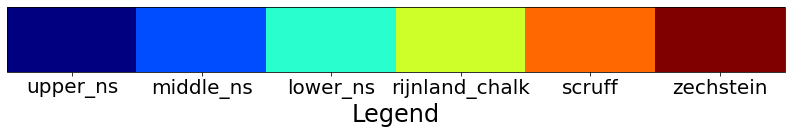

In [12]:
cmap = discrete_cmap(len(config["name_classes"]), 'jet')
show_legend(config["name_classes"], cmap)
viewer_interpret_data = view(predicted_data, shadow=False)
viewer_interpret_data.cmap = cmap
widgets.link((viewer_interpret_data, 'camera'), (viewer_orig_data, 'camera')) # link widget cameras
pass

* Run render

In [13]:
viewer_interpret_data

Viewer(cmap='Custom matplotlib 1611681079.335274', geometries=[], gradient_opacity=0.22, point_sets=[], render…

In [14]:
viewer_orig_data

Viewer(camera=array([[ 281.96365, -299.58627,  338.22418],
       [  60.5    ,   84.     ,   82.5    ],
      …